# Генерация систем непрерывных и дискретных случайных величин

In [1]:
import math
import random as r
import numpy as np
import scipy.stats as st
import scipy.integrate as _in
import matplotlib.pyplot as plt

## Формирование двумерной НСВ
### Генерация значений

In [2]:
# 7th variant function (edited)
fxy = lambda x, y: math.cos(x - y) / 2

# function params
a = 0
b = math.pi / 2
fxy_max = 0.5

n = 10000

x_l, y_l = [], []
for _ in range(n):
    while True:
        x_, y_ = (a + r.random() * (b - a) for _ in range(2))
        z_ = r.random() * fxy_max
        if fxy(x_, y_) > z_:
            x_l.append(x_)
            y_l.append(y_)
            break

### Статистические исследования
#### Мат. ожидания, дисперии, коэффициенты корреляции

In [3]:
M_f = lambda l: sum(l) / n
D_f = lambda l: sum(e ** 2 for e in l) / n - M_f(l) ** 2
r_f = lambda M_xy, M_x, M_y, D_x, D_y: (M_xy - M_x * M_y) / math.sqrt(D_x * D_y)

# In my variant one value for both variable
_kwargs = {
    'a': a,
    'b': b,
    'gfun': lambda x: a,
    'hfun': lambda x: b
}
M_th = _in.dblquad(lambda x, y: x * math.cos(x - y) / 2, **_kwargs)[0]
M_th_2 = _in.dblquad(lambda x, y: x ** 2 * math.cos(x - y) / 2, **_kwargs)[0]
D_th = M_th_2 - M_th ** 2
M_xy_th = _in.dblquad(lambda x, y: x * y * math.cos(x - y) / 2, **_kwargs)[0]

print('Теоретические характеристики')
print('M[x] =', M_th, 'D[x] =', D_th)
print('M[y] =', M_th, 'D[y] =', D_th)
print('r[xy] =', r_f(M_xy_th, M_th, M_th, D_th, D_th))
print()
print('Полученные характеристики')
print('M[x] =', M_f(x_l), 'D[x] =', D_f(x_l))
print('M[y] =', M_f(y_l), 'D[y] =', D_f(y_l))
print('r[xy] =', st.pearsonr(x_l, y_l)[0])

Теоретические характеристики
M[x] = 0.7853981633974483 D[x] = 0.18764660186298154
M[y] = 0.7853981633974483 D[y] = 0.18764660186298154
r[xy] = 0.24542916213754049

Полученные характеристики
M[x] = 0.7808566900826145 D[x] = 0.18783235255079778
M[y] = 0.784938841718032 D[y] = 0.18638101564366694
r[xy] = 0.25885357965548883


#### Гистограммы

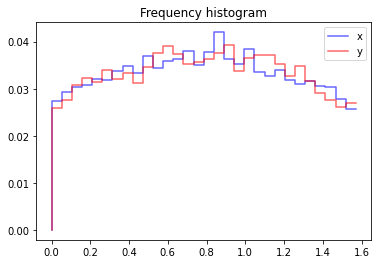

In [4]:
K = 30
d = (b - a) / K
di_l = [i * d for i in range(K + 1)]

def draw_plot(l, **kwargs):
    v_l = [
        len(list(filter(lambda v: di - d <= v < di, l))) / n
        for di in di_l
    ]
    plt.plot(di_l, v_l, drawstyle='steps-pre', alpha=0.6, **kwargs)


draw_plot(x_l, label='x', color='b')
draw_plot(y_l, label='y', color='r')

plt.title(f'Frequency histogram')
plt.legend()
plt.show()

#### График функции

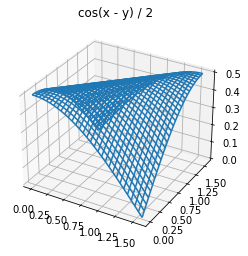

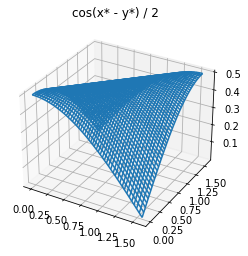

In [5]:
def draw_3d_plot(x_l, y_l, title=None):
    x, y = np.meshgrid(x_l, y_l)
    z = np.cos(x - y) / 2
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_wireframe(x, y, z)
    ax.set_title(title)
    plt.show()
    
draw_3d_plot(di_l, di_l, 'cos(x - y) / 2')
draw_3d_plot(sorted(x_l), sorted(y_l), 'cos(x* - y*) / 2')

## Формирование двумерной ДСВ

In [6]:
X = [1, 2, 3, 4, 5]
Y = [10, 20, 30, 40, 50]
P = [
    [0, 0, 0.05, 0.05, 0.1],
    [0.025, 0.025, 0.025, 0.025, 0.04],
    [0.05, 0.025, 0, 0, 0.1],
    [0.11, 0.07, 0.03, 0.05, 0.055],
    [0.070, 0.05, 0.05, 0, 0]
]

p_x = [sum(row) for row in P]
p_y = [sum(y) for y in zip(*P)]

p_yi = [[y / p_x[i] for y in row] for i, row in enumerate(P)]

F_x = np.cumsum(p_x)
F_y = [np.cumsum(p_yi[i]) for i in range(len(Y))]

### Генерация значений

In [7]:
def get_var_and_index(x, F_x, p):
    '''
    Get the value of random variable and index by probability.
    '''
    return next((x[i], i) for i, p_ in enumerate(F_x) if p_ >= p)

n = 10000

x_l, y_l = [], []
for _ in range(n):
    x, i = get_var_and_index(X, F_x, r.random())
    x_l.append(x)
    y_l.append(get_var_and_index(Y, F_y[i], r.random())[0])
    
p_x_imp = [x_l.count(X[i]) / n for i in range(len(X))]
p_y_imp = [y_l.count(Y[i]) / n for i in range(len(Y))]

### Статистические исследования

In [8]:
M_f = lambda v, p_v: sum([v[i] * p_v[i] for i in range(len(v))])

def D_f(v, p_v, M=None):
    if M is None:
        M = M_f(v, p_v)
    return sum([(v[i] ** 2) * p_v[i] for i in range(len(v))]) - M ** 2

M_x = M_f(X, p_x)
M_y = M_f(Y, p_y)
M_xy = sum([
    sum([x * y * P[i][j] for j, y in enumerate(Y)])
    for i, x in enumerate(X)
])
D_x = D_f(X, p_x, M_x)
D_y = D_f(Y, p_y, M_y)

print('Теоретические характеристики')
print('M[x] =', M_x, 'D[x] =', D_x)
print('M[y] =', M_y, 'D[y] =', D_y)
print('r[xy] =', r_f(M_xy, M_x, M_y, D_x, D_y))
print()
print('Эмпирические характеристики')
print('M[x] =', M_f(X, p_x_imp), 'D[x] =', D_f(X, p_x_imp))
print('M[y] =', M_f(Y, p_y_imp), 'D[y] =', D_f(Y, p_y_imp))
print('r =', st.pearsonr(x_l, y_l)[0])


Теоретические характеристики
M[x] = 3.115 D[x] = 1.9217749999999985
M[y] = 30.35 D[y] = 249.37749999999994
r[xy] = -0.47690403306892665

Эмпирические характеристики
M[x] = 3.0959999999999996 D[x] = 1.9269840000000027
M[y] = 30.826999999999998 D[y] = 246.44607100000007
r[xy] = -0.47578572153295107


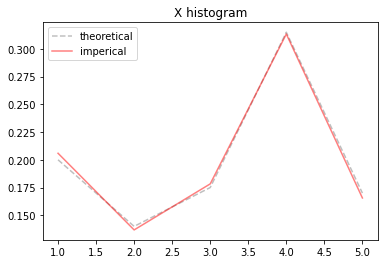

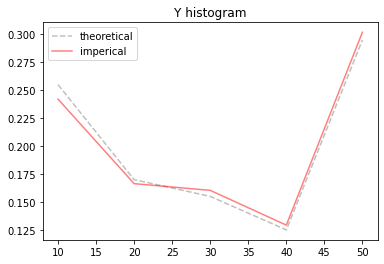

In [9]:
def draw_plot(v, p_v, p_v_imp, var_name):
    plt.plot(v, p_v, label='theoretical', color='gray', alpha=0.5, ls='--')
    plt.plot(v, p_v_imp, label=f'imperical', color='r', alpha=0.5)
    plt.title(f'{var_name} histogram')
    plt.legend()
    plt.show()

draw_plot(X, p_x, p_x_imp, 'X')
draw_plot(Y, p_y, p_y_imp, 'Y')